In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as T
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from PIL import Image
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from collections import Counter

import albumentations as A
from albumentations.pytorch import ToTensorV2

from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor

In [ ]:
# --- Config ---
NUM_CLASSES = 7
IMAGE_SIZE = (512, 512)
BATCH_SIZE = 4
EPOCHS = 30
PATIENCE = 5

# For AdamW optimizer
LEARNING_RATE = 1e-4
WEIGHT_Decay = 0.1
Beta1 = 0.95
Beta2 = 0.9999

# Learning rate schedular ReduceLROnPlateau
lrS_patience = 5
lrS_factor = 0.1 # 0.5

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", DEVICE)

Using device: cuda


In [ ]:
# RGB to Class Mapping
rgb_to_class = {
    (0, 255, 255): 0,     # urbanland
    (255, 255, 0): 1,     # agricultureland
    (255, 0, 255): 2,     # rangeland
    (0, 255, 0): 3,       # forestland
    (0, 0, 255): 4,       # water
    (255, 255, 255): 5,   # barrenland
    (0, 0, 0): 6,         # unknown

}

# Class to RGB Mapping for visualization
class_to_rgb = {v: k for k, v in rgb_to_class.items()}

In [ ]:
def rgb_mask_to_class(mask):
    """Convert RGB mask to 2D class index mask."""
    mask = np.array(mask)
    class_mask = np.zeros(mask.shape[:2], dtype=np.uint8)
    for rgb, idx in rgb_to_class.items():
        class_mask[(mask == rgb).all(axis=-1)] = idx
    return class_mask

In [ ]:
# DeepGlobe Paths
deepglobe_dir = "/content/drive/MyDrive/Study_Related/MSCS_GeorgiaTech/CS_7643_Deep_Learning/Project/CS7643_Geospatial_Project/Dataset/DeepGlobe2018/train"

# Load DeepGlobe images and masks
deepglobe_images = sorted(glob(os.path.join(deepglobe_dir, "*.jpg")))
deepglobe_masks = sorted(glob(os.path.join(deepglobe_dir, "*.png")))

print(f"Loaded {len(deepglobe_images)} DeepGlobe images")

Loaded 803 DeepGlobe images


In [ ]:
# Combine both datasets
all_images = deepglobe_images
all_masks = deepglobe_masks
sources = ['deepglobe'] * len(deepglobe_images)

# Train/Val Split (Stratified)
train_imgs, val_imgs, train_masks, val_masks, train_sources, val_sources = train_test_split(
    all_images, all_masks, sources, test_size=0.2, stratify=sources, random_state=42
)

# Utility to print split info
def print_split_info(name, source_list):
    counts = Counter(source_list)
    print(f"{name} Set:")
    for dataset, count in counts.items():
        print(f"  {dataset}: {count} images")
    print(f"  Total: {len(source_list)} images\n")

print_split_info("Train", train_sources)
print_split_info("Validation", val_sources)

Train Set:
  deepglobe: 642 images
  Total: 642 images

Validation Set:
  deepglobe: 161 images
  Total: 161 images



In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = np.array(Image.open(self.image_paths[idx]).convert('RGB'))
        mask = Image.open(self.mask_paths[idx]).convert('RGB')
        mask = rgb_mask_to_class(mask)
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
        else:
            img = T.ToTensor()(img)

        return img.float(), mask.long()

In [ ]:
# Albumentations transforms
train_transform = A.Compose([
    A.Resize(IMAGE_SIZE[0], IMAGE_SIZE[1]),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(IMAGE_SIZE[0], IMAGE_SIZE[1]),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [ ]:
# Create datasets
train_dataset = SegmentationDataset(train_imgs, train_masks, transform=train_transform)
val_dataset = SegmentationDataset(val_imgs, val_masks, transform=val_transform)

# Weighted sampling to balance smaller Dubai dataset
source_counts = Counter(train_sources)
weights = [1.0 / source_counts[src] for src in train_sources]
train_sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=2) #sampler=train_sampler
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Train batches: {len(train_loader)} | Val batches: {len(val_loader)}")

Train batches: 161 | Val batches: 41


In [ ]:
# Load Hugging Face Segformer-B3 model
model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b3-finetuned-ade-512-512",
    num_labels=NUM_CLASSES,
    ignore_mismatched_sizes=True
).to(DEVICE)

# Feature extractor (optional – you’re not using it directly now, but keep it for completeness)
feature_extractor = SegformerFeatureExtractor(do_reduce_labels=False, size=IMAGE_SIZE)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/190M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/189M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b3-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([7, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:30: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(


In [ ]:
# Load Hugging Face Segformer-B3 model
model = SegformerForSemanticSegmentation.from_pretrained(
    "nave1616/SegFormer-landcover-FT",
    num_labels=NUM_CLASSES,
    ignore_mismatched_sizes=True
).to(DEVICE)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nave1616/SegFormer-landcover-FT and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([9]) in the checkpoint and torch.Size([7]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([9, 768, 1, 1]) in the checkpoint and torch.Size([7, 768, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

106

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        preds = torch.softmax(preds, dim=1)
        targets_one_hot = torch.nn.functional.one_hot(targets, NUM_CLASSES).permute(0, 3, 1, 2).float()

        intersection = (preds * targets_one_hot).sum(dim=(2, 3))
        union = preds.sum(dim=(2, 3)) + targets_one_hot.sum(dim=(2, 3))

        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, preds, targets):
        logpt = -torch.nn.functional.cross_entropy(preds, targets, reduction='none')
        pt = torch.exp(logpt)
        loss = -((1 - pt) ** self.gamma) * logpt
        return loss.mean()

class CombinedLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super().__init__()
        self.dice = DiceLoss()
        self.focal = FocalLoss(alpha, gamma)

    def forward(self, preds, targets):
        return self.dice(preds, targets) + self.focal(preds, targets)


In [ ]:
def compute_metrics(preds, targets, num_classes=NUM_CLASSES):
    preds = torch.argmax(preds, dim=1).detach().cpu().numpy()
    targets = targets.detach().cpu().numpy()

    ious, f1s = [], []
    correct, total = 0, 0

    for cls in range(num_classes):
        pred_cls = (preds == cls)
        true_cls = (targets == cls)

        intersection = (pred_cls & true_cls).sum()
        union = (pred_cls | true_cls).sum()
        if union > 0:
            iou = intersection / union
            ious.append(iou)
        else:
            ious.append(np.nan)

        f1 = (2 * intersection) / (pred_cls.sum() + true_cls.sum() + 1e-6)
        f1s.append(f1)

        correct += (pred_cls == true_cls).sum()
        total += true_cls.size

    return {
        "Pixel Accuracy": correct / total,
        "Mean IoU": np.nanmean(ious),
        "Mean F1": np.nanmean(f1s)
    }

In [ ]:
def train_one_epoch(model, loader, optimizer, loss_fn):
    model.train()
    epoch_loss = 0
    for imgs, masks in tqdm(loader, desc="Training", leave=False):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(pixel_values=imgs).logits
        outputs = torch.nn.functional.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=False)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(loader)

def validate_one_epoch(model, loader, loss_fn):
    model.eval()
    val_loss = 0
    metrics_total = {"Pixel Accuracy": [], "Mean IoU": [], "Mean F1": []}

    with torch.no_grad():
        for imgs, masks in tqdm(loader, desc="Validation", leave=False):
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
            outputs = model(pixel_values=imgs).logits
            outputs = torch.nn.functional.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=False)
            loss = loss_fn(outputs, masks)
            val_loss += loss.item()

            metrics = compute_metrics(outputs, masks)
            for k in metrics:
                metrics_total[k].append(metrics[k])

    avg_metrics = {k: np.mean(v) for k, v in metrics_total.items()}
    return val_loss / len(loader), avg_metrics


In [ ]:
loss_fn = CombinedLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, betas=(Beta1, Beta2), weight_decay=WEIGHT_Decay)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=lrS_patience, factor=lrS_factor, verbose=True)

best_miou = 0
patience_counter = 0

history = {
    "train_loss": [],
    "val_loss": [],
    "val_pixel_acc": [],
    "val_miou": [],
    "val_f1": []
}

for epoch in range(1, EPOCHS + 1):
    print(f"\n Epoch {epoch}/{EPOCHS}")

    train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn)
    val_loss, val_metrics = validate_one_epoch(model, val_loader, loss_fn)

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    for k, v in val_metrics.items():
        print(f"{k}: {v:.4f}")

    scheduler.step(val_loss)

    # Save history
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_pixel_acc"].append(val_metrics["Pixel Accuracy"])
    history["val_miou"].append(val_metrics["Mean IoU"])
    history["val_f1"].append(val_metrics["Mean F1"])

    # Save best model
    if val_metrics["Mean IoU"] > best_miou:
        best_miou = val_metrics["Mean IoU"]
        torch.save(model.state_dict(), "best_model.pth")
        print("Best model saved!")
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= PATIENCE:
        print("Early stopping triggered.")
        break



 Epoch 1/30


Train Loss: 1.3436 | Val Loss: 1.0875
Pixel Accuracy: 0.9480
Mean IoU: 0.4318
Mean F1: 0.4502
Best model saved!

 Epoch 2/30


Train Loss: 1.0302 | Val Loss: 1.0071
Pixel Accuracy: 0.9554
Mean IoU: 0.4640
Mean F1: 0.4759
Best model saved!

 Epoch 3/30


Train Loss: 0.9302 | Val Loss: 1.0040
Pixel Accuracy: 0.9561
Mean IoU: 0.4971
Mean F1: 0.5041
Best model saved!

 Epoch 4/30


Train Loss: 0.8755 | Val Loss: 1.0446
Pixel Accuracy: 0.9513
Mean IoU: 0.4763
Mean F1: 0.4924

 Epoch 5/30


Train Loss: 0.8449 | Val Loss: 1.0229
Pixel Accuracy: 0.9555
Mean IoU: 0.4792
Mean F1: 0.4878

 Epoch 6/30


Train Loss: 0.8168 | Val Loss: 1.0183
Pixel Accuracy: 0.9557
Mean IoU: 0.5151
Mean F1: 0.5181
Best model saved!

 Epoch 7/30


Train Loss: 0.7846 | Val Loss: 1.0132
Pixel Accuracy: 0.9575
Mean IoU: 0.5152
Mean F1: 0.5164
Best model saved!

 Epoch 8/30


Train Loss: 0.7550 | Val Loss: 1.0315
Pixel Accuracy: 0.9582
Mean IoU: 0.5202
Mean F1: 0.5182
Best model saved!

 Epoch 9/30


Train Loss: 0.7279 | Val Loss: 1.0483
Pixel Accuracy: 0.9585
Mean IoU: 0.5113
Mean F1: 0.5196

 Epoch 10/30


Train Loss: 0.7075 | Val Loss: 0.9606
Pixel Accuracy: 0.9619
Mean IoU: 0.5418
Mean F1: 0.5457
Best model saved!

 Epoch 11/30


Train Loss: 0.6909 | Val Loss: 0.9617
Pixel Accuracy: 0.9622
Mean IoU: 0.5408
Mean F1: 0.5456

 Epoch 12/30


Train Loss: 0.6836 | Val Loss: 0.9637
Pixel Accuracy: 0.9626
Mean IoU: 0.5414
Mean F1: 0.5461

 Epoch 13/30


Train Loss: 0.6781 | Val Loss: 0.9675
Pixel Accuracy: 0.9627
Mean IoU: 0.5426
Mean F1: 0.5464
Best model saved!

 Epoch 14/30


Train Loss: 0.6735 | Val Loss: 0.9724
Pixel Accuracy: 0.9625
Mean IoU: 0.5406
Mean F1: 0.5451

 Epoch 15/30


Train Loss: 0.6691 | Val Loss: 0.9802
Pixel Accuracy: 0.9624
Mean IoU: 0.5401
Mean F1: 0.5438

 Epoch 16/30


Train Loss: 0.6647 | Val Loss: 0.9827
Pixel Accuracy: 0.9626
Mean IoU: 0.5391
Mean F1: 0.5449

 Epoch 17/30


Train Loss: 0.6614 | Val Loss: 0.9828
Pixel Accuracy: 0.9626
Mean IoU: 0.5400
Mean F1: 0.5458

 Epoch 18/30


Train Loss: 0.6614 | Val Loss: 0.9829
Pixel Accuracy: 0.9626
Mean IoU: 0.5400
Mean F1: 0.5457
Early stopping triggered.


In [ ]:
def plot_training_history(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(18, 12))

    # Train vs Val Loss
    plt.subplot(2, 3, 1)
    plt.plot(epochs, history["train_loss"], label='Train Loss')
    plt.plot(epochs, history["val_loss"], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Pixel Accuracy
    plt.subplot(2, 3, 2)
    plt.plot(epochs, history["val_pixel_acc"], label='Pixel Accuracy')
    plt.title('Pixel Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Mean IoU
    plt.subplot(2, 3, 3)
    plt.plot(epochs, history["val_miou"], label='Mean IoU')
    plt.title('Mean IoU')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()

    # F1 Score
    plt.subplot(2, 3, 5)
    plt.plot(epochs, history["val_f1"], label='F1 Score')
    plt.title('F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def class_mask_to_rgb(mask):
    """Convert a class-indexed mask to RGB."""
    h, w = mask.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for class_idx, color in class_to_rgb.items():
        rgb[mask == class_idx] = color
    return rgb

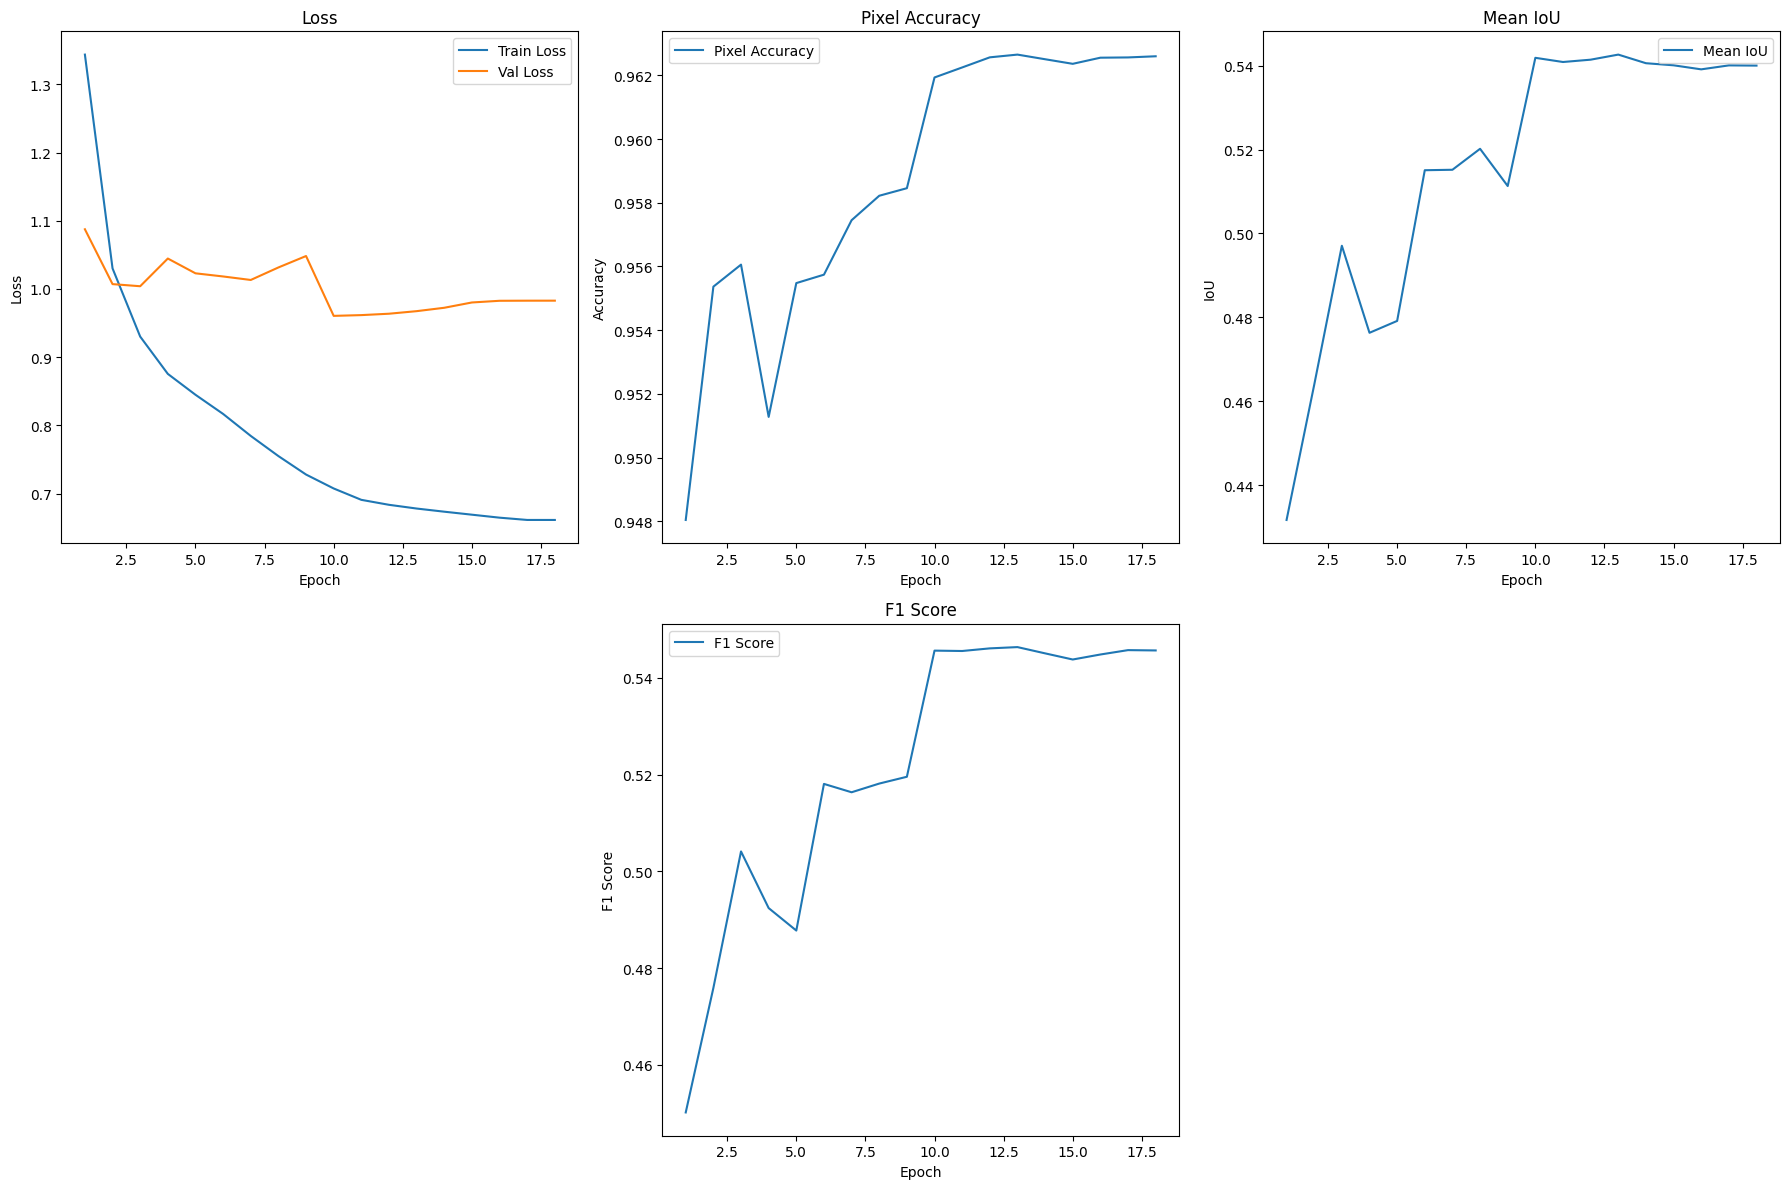

In [ ]:
# Plot training performance
plot_training_history(history)

In [ ]:
def calculate_iou_and_f1(pred, target, num_classes=NUM_CLASSES):
    ious = []
    f1s = []
    for cls in range(num_classes):
        pred_cls = (pred == cls)
        target_cls = (target == cls)
        intersection = np.logical_and(pred_cls, target_cls).sum()
        union = np.logical_or(pred_cls, target_cls).sum()
        if union == 0:
            iou = float('nan')
        else:
            iou = intersection / union
        f1 = (2 * intersection) / (pred_cls.sum() + target_cls.sum() + 1e-6)
        ious.append(iou)
        f1s.append(f1)
    return np.nanmean(ious), np.nanmean(f1s)


def visualize_predictions(model, dataset, num_samples):
    model.eval()
    indices = random.sample(range(len(dataset)), num_samples)

    plt.figure(figsize=(15, num_samples * 3))

    for i, idx in enumerate(indices):
        img, gt_mask = dataset[idx]
        img_input = img.unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            output = model(pixel_values=img_input).logits
            output = torch.nn.functional.interpolate(output, size=gt_mask.shape, mode='bilinear', align_corners=False)
            pred_mask = torch.argmax(output.squeeze(), dim=0).cpu().numpy()

        # Compute metrics
        mean_iou, f1 = calculate_iou_and_f1(pred_mask, gt_mask.numpy())

        # Convert to RGB
        rgb_gt = class_mask_to_rgb(gt_mask.numpy())
        rgb_pred = class_mask_to_rgb(pred_mask)
        img_np = img.permute(1, 2, 0).cpu().numpy()
        img_np = (img_np * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
        img_np = np.clip(img_np * 255, 0, 255).astype(np.uint8)

        # Show row
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(img_np)
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(rgb_gt)
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(rgb_pred)
        plt.title(f"Prediction\nF1: {f1:.2f} | IoU: {mean_iou:.2f}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
# Show predictions
visualize_predictions(model, val_dataset, num_samples=20)